In [1]:
from fastbook import search_images_ddg, DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, Resize, DataLoaders, DataLoader, PILImage
from fastdownload import download_url
from fastcore.all import L
from fastai.vision.all import download_images, Image, resize_images, verify_images, get_image_files, vision_learner, resnet18, error_rate, ClassificationInterpretation, accuracy
from fastai.vision.widgets import ImageClassifierCleaner, shutil
from pathlib import Path
from time import sleep

# grab 20 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:
searches = 'forest','bird'
path = Path('./img/birds')

if not path.exists():
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        
        download_images(dest, urls= search_images_ddg(f'{o} photo')[:20])
        resize_images(dest, max_size=400, dest=dest)
        
# failed = verify_images(get_image_files(path))
# failed.map(Path.unlink)
# len(failed)

d:\Python312\Lib\site-packages\torch\_tensor.py:1418: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
  ret = func(*args, **kwargs)


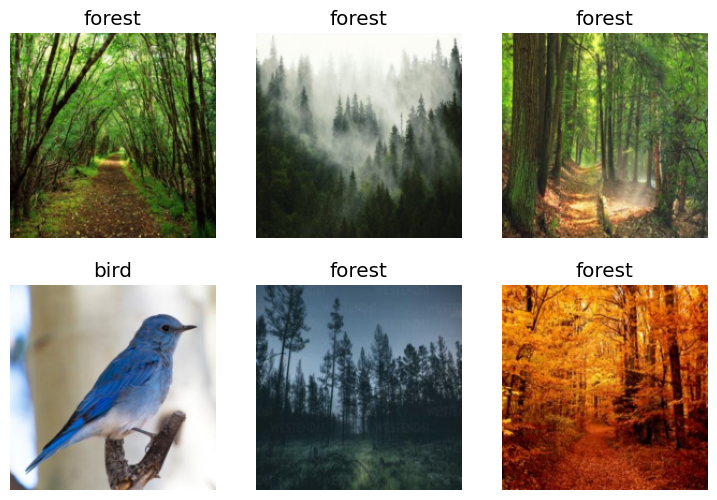

In [2]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path,bs=6)

dls.show_batch(max_n=6)

In [3]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.530907,0.452389,0.428571,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.085324,0.038978,0.000000,00:00
1,0.049452,0.003937,0.000000,00:00
2,0.147370,0.001818,0.000000,00:00


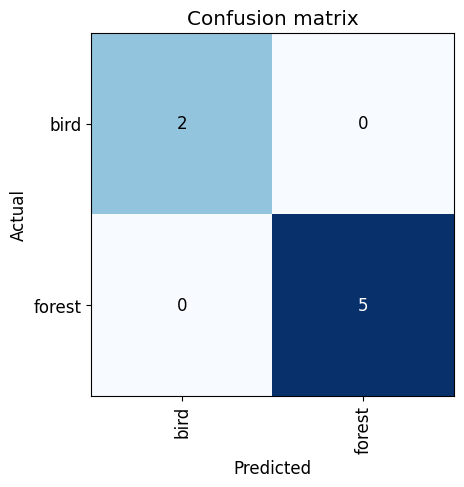

In [4]:
# Improving the model: data cleaning and augmentations
# First, let’s see the model’s errors: whether it can’t distinguish corgi from husky or pomeranian from retriever. We can use confusion_matrix for it.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

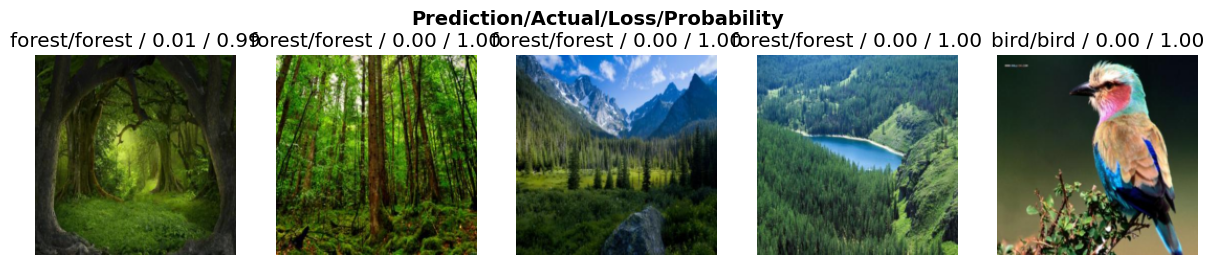

In [5]:
# images with the highest loss: it could be cases where the model was wrong with high confidence or correct but with low confidence.
interp.plot_top_losses(5, nrows=1)

In [6]:
#clean
cleaner = ImageClassifierCleaner(learn)
cleaner

In [7]:
# After each category, you can run the following code to fix issues: delete the image or move it to the correct folder.
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,breed in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/breed)

In [8]:
#now, we can train our model again:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.040800,0.762912,0.571429,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.026529,0.072562,1.000000,00:00
1,0.203164,0.001525,1.000000,00:00
2,0.167223,0.000628,1.000000,00:00


In [9]:
# download model
learn.export('bird_model.pkl')

In [12]:
is_bird,_,probs = learn.predict(PILImage.create('./img/birds/forest/11feb19d-c014-4782-95df-9814fec7e5ba.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0000
